# MScausality application to Leutert et al. PTM study

In [1]:
from MScausality.causal_model.LVM import LVM
from MScausality.data_analysis.normalization import normalize
import pyro

import pandas as pd
import numpy as np
from gprofiler import GProfiler
from bioservices import BioMart

import math

# Graphs
import networkx as nx
from y0.graph import NxMixedGraph
from y0.dsl import Variable
from eliater.network_validation import print_graph_falsifications, add_ci_undirected_edges
from eliater.regression import summary_statistics, fit_regression

from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from scipy.stats import t, linregress
import statsmodels.api as sm

import xgboost as xgb

import scipy

# Plots
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/root/miniconda3/envs/py310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load and prepare data

### Specify which treatments to remove

These treatments should not be included in validation or testing.
    
- 120 min treatment time

In [2]:
remove = ["AF2", "HU2", "NO2"]

mapper = pd.read_csv("../../../data/Leutert/mapper.tsv", sep="\t",
                     skiprows=1,
                     names=["DBID", "SGD_ID", "Organism", "Gene", "LongGene"])
mapper.head()

,DBID,SGD_ID,Organism,Gene,LongGene
0,SGD:S000000001,YAL001C,S. cerevisiae,TFC3,Transcription Factor class C
1,SGD:S000000002,YAL002W,S. cerevisiae,VPS8,Vacuolar Protein Sorting
2,SGD:S000000003,YAL003W,S. cerevisiae,EFB1,Elongation Factor Beta
3,SGD:S000000004,YAL005C,S. cerevisiae,SSA1,Stress-Seventy subfamily A
4,SGD:S000000007,YAL009W,S. cerevisiae,SPO7,SPOrulation


### Model data

In [3]:
# model_data = pd.read_csv('../../../data/Leutert/test_model.csv')
model_data = pd.read_csv('../../../data/Leutert/new_ptm_model.csv')
treatment_info = pd.read_csv('../../../data/Leutert/treatment_info.csv')

model_data = model_data[np.isfinite(model_data["log2FC"])]
# model["log2FC"] = abs(model["log2FC"])
model_data.loc[:, "Label"] = model_data.loc[:, "Label"].str.split("-").str[0]

model_data = pd.merge(model_data, 
                 treatment_info.loc[:, ["treatment_id", 
                                        "treatment_type", 
                                        "phenotype_screened"]], 
                 left_on="Label", right_on="treatment_id",
                 how="left")

# Initialize GProfiler
gp = GProfiler(return_dataframe=True)

# Example systematic names
systematic_names = list(model_data.loc[:, "Protein"].unique())
filtered_list = [x for x in systematic_names if not isinstance(x, float) or not math.isnan(x)]

# Query GProfiler
# results = gp.convert(query=filtered_list, organism='scerevisiae', target_namespace='ENSG')
# gene_names = [id_to_gene.get(yeast_id, "Unknown") for yeast_id in filtered_list]
# results = pd.DataFrame({"incoming": filtered_list, "name": gene_names})

model_data = pd.merge(model_data, mapper.loc[:, ["SGD_ID", "Gene"]],
         left_on="Protein", right_on="SGD_ID", how="left")
model_data.loc[:, "Protein"] = model_data.loc[:, "Gene"]
model_data = model_data.drop(columns=["SGD_ID", "Gene"])
model_data = model_data[~model_data["Protein"].isin(remove)]
model_data.head()

,Protein,Label,log2FC,SE,Tvalue,DF,pvalue,adj.pvalue,issue,MissingPercentage,ImputationPercentage,treatment_id,treatment_type,phenotype_screened
0,TFC3,AA,1.008000,0.932446,1.081027,72.0,0.283293,0.992139,NaN,0.833333,0.0,AA,pH,growth (pooled culture)
1,TFC3,AB,0.612237,0.932446,0.656592,72.0,0.513537,0.936472,NaN,0.750000,0.0,AB,cell wall,growth (colony size)
2,TFC3,AF,0.114005,0.722270,0.157843,72.0,0.875022,0.999970,NaN,0.800000,0.0,AF,drug,transcription
3,TFC3,AF2,0.290889,0.932446,0.311964,72.0,0.755970,0.966048,NaN,0.636364,0.0,AF2,cell cylce,transcription
4,TFC3,AN,0.066580,0.636982,0.104524,72.0,0.917044,0.999921,NaN,0.666667,0.0,AN,DNA,growth


In [ ]:
model_data[(model_data["Label"] == "CF") & 
           (model_data["Protein"] == "KOG1")]

,Protein,Label,log2FC,SE,Tvalue,DF,pvalue,adj.pvalue,issue,MissingPercentage,ImputationPercentage,treatment_id,treatment_type,phenotype_screened
92281,KOG1,CF,-3.379449,0.640081,-5.27972,390.0,2.153697e-07,0.000039,NaN,0.5,0.0,CF,drug,growth


In [ ]:
model_data[(model_data["Label"] == "CF") & 
           (model_data["pvalue"] < .05)]["Protein"].values

array(['VPS8', 'BUD14', 'TOD6', 'MAP2', 'RTG3', 'BAP2', 'SHE3', 'AMN1',
       'NGR1', 'ADF1', nan, 'RIM1', 'ELO2', 'HCM1', 'RPS29B', 'NUR1',
       'MFG1', 'NTH1', 'MAK21', 'TAF12', 'SEC5', 'CDC1', 'SIR4', 'PAM1',
       'PAL1', 'SBE2', 'YPQ2', 'ARO80', 'SIP1', 'YHP1', 'PSP1', 'EDC3',
       'GLN3', 'FCY21', 'MET6', 'BOI2', 'SLX8', 'ECM32', 'BLM10', 'GAT1',
       'RET2', 'PMA1', 'PDR1', 'PGD1', 'VPS73', 'MON1', 'ARO2', 'MIG2',
       'HXK2', 'STF2', 'RME1', 'DBF2', 'ASK10', 'MDR1', 'NUP57', 'VSB1',
       nan, 'TPO2', 'SKN1', 'NSR1', 'ADE3', 'RIE1', 'KSP1', 'SBE22', nan,
       'MPC2', 'KOG1', 'SCH9', 'BAT1', 'BCY1', 'AGE2', 'SYG1', 'MAM33',
       'HOS4', nan, 'MGA2', 'CYR1', 'VPS53', 'BIT61', 'IML2', 'YAK1',
       'FAR1', 'AUR1', 'CDC16', 'MSN4', 'UTP11', 'VPH2', 'YPK1', 'IRS4',
       'SPO14', 'NAP1', 'RHO4', 'GPT2', 'SIS2', 'TGL4', 'PXL1', 'TPO1',
       'YBT1', 'RLP24', 'RAD5', 'LAM6', 'ZRT2', 'SKG3', 'IMH1', 'CDC25',
       'RPS29A', 'RPN13', 'TUS1', 'ECM30', 'MRPL4', 'BUL2', 

### Summarized PTM-level data

In [6]:
summarized_data = pd.read_csv('../../../data/Leutert/ptm_summarized_data.csv')

summarized_data = pd.merge(summarized_data, 
                           treatment_info.loc[:, ["treatment_id", 
                                                  "treatment_type", 
                                                  "phenotype_screened"]], 
                            left_on="GROUP", right_on="treatment_id",
                            how="left")

systematic_names = list(summarized_data.loc[:, "Protein"].unique())

# Query GProfiler
# results = gp.convert(query=systematic_names, 
#                      organism='scerevisiae', 
#                      target_namespace='ENSG')

summarized_data = pd.merge(summarized_data, 
                           mapper.loc[:, ["SGD_ID", "Gene"]],
                           left_on="Protein", right_on="SGD_ID", how="left")
# summarized_data = summarized_data[~summarized_data["Protein"].isin(remove)]
summarized_data = summarized_data[summarized_data["treatment_type"].isin(['control'])]#'growth',
# summarized_data = summarized_data[summarized_data["GROUP"] == 'UT']

summarized_data.head()
input = summarized_data.pivot_table(index="RUN", 
                              columns="Gene", 
                              values="LogIntensities", aggfunc='mean')
summarized_data

,RUN,Protein,LogIntensities,originalRUN,GROUP,SUBJECT,TotalGroupMeasurements,NumMeasuredFeature,MissingPercentage,more50missing,NumImputedFeature,treatment_id,treatment_type,phenotype_screened,SGD_ID,Gene
66,180,YAL001C,11.165042,x00705,DM,DM.45_3,45,1,0.888889,True,0,DM,control,control,YAL001C,TFC3
67,181,YAL001C,11.749432,x03310,DM,DM.45_4,45,1,0.888889,True,0,DM,control,control,YAL001C,TFC3
68,182,YAL001C,12.788051,x01702,DM,DM.45_6,45,1,0.888889,True,0,DM,control,control,YAL001C,TFC3
171,494,YAL001C,12.366392,x03276,UT,UT.108_3,207,1,0.888889,True,0,UT,control,control,YAL001C,TFC3
172,497,YAL001C,11.657502,x01603,UT,UT.108_6,207,1,0.888889,True,0,UT,control,control,YAL001C,TFC3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
879039,519,YPR190C,13.923267,x03360,UTF,UTF.32_4,78,2,0.846154,True,0,UTF,control,control,YPR190C,RPC82
879040,520,YPR190C,11.471208,x01340,UTF,UTF.32_5,78,3,0.769231,True,0,UTF,control,control,YPR190C,RPC82
879041,521,YPR190C,13.440175,x01655,UTF,UTF.32_6,78,3,0.769231,True,0,UTF,control,control,YPR190C,RPC82
879094,182,YPR191W,12.962111,x01702,DM,DM.45_6,15,1,0.666667,True,0,DM,control,control,YPR191W,QCR2


To avoid double-dipping, we use half the data to test conditional 
independencies and build the graph, and the other half for model fitting.

In [7]:
input.loc[:, ["SCH9", "KOG1"]]

Gene,SCH9,KOG1
RUN,,
178,17.780460,12.713429
179,14.172671,13.755071
180,15.633449,13.693940
181,17.002695,13.440433
182,14.631938,11.561569
493,16.687743,11.940066
494,15.912157,12.241482
495,11.316562,11.494826
496,15.498818,11.636984


## TOR network


### Define base graph

In [8]:
input["RIM15"]

RUN
178    15.537099
179          NaN
180    10.357167
181    14.041862
182    12.967035
493    15.998469
494    15.729991
495    15.962913
496    14.862232
497    14.408748
498    14.338871
499    15.710390
500    16.004449
501    15.581436
502    14.628112
503    15.808805
504    14.728835
505    14.522969
506    14.733769
507    14.700883
508    15.355020
509    15.348006
510    14.579459
511    14.749127
512    15.096679
513    15.082812
514    14.065889
515    14.595077
516    15.931860
517    14.064878
518    14.037139
519    15.504722
520    14.243825
521    14.471619
Name: RIM15, dtype: float64

In [10]:
def tor_network():

    graph = nx.DiGraph()

    torc1 = "KOG1"#KOG1

    ## Add edges
    graph.add_edge(torc1, "SCH9")
    graph.add_edge(torc1, "GIS1")
    graph.add_edge("SCH9", "GIS1")

    graph.add_edge(torc1, "GCN2")
    graph.add_edge("GCN2", "SUI2")
    # graph.add_edge("SUI2", "GCN4")
                                     
    
    # Stress response genes
    # sr_genes = ["VPS1", "MSN2", "YAK1", "LST4", "TGL4",
    #             "HSP104", "SSA3", "HSP26", "HSP42", "GPD1", "SOD1",  
    #             "TRX1", "HOG1", "SNF1", "RTG1", "RTG2", 
    #             "RTG3", "TPS2", "ENA1", "NHX1", "VMA1", "VMA10", "VMA13",
    #             "VMA2", "VMA4", "VMA8", "RAD52", "RNR1", "RNR2", 
    #             "KAR2", "IRE1", 
    #             "DGA1", "HSP12", "HSP30", "DOT6", "YSP2", "MCA1", "URE2", 
    #             "ATG13", "CRZ1","SLG1", "TSC11", "RAS2", "SLM1","TRM13"]
    sr_genes = ["RIM15"]
    
    # sr_genes = ['TOD6', 'RTG3', 'TGL4', 'SLM2', 'YPK1', 'BUL2', 'GAT1', 'GAT2', 'GLN3']
    # sr_genes = ["HSP12", "HSP26", "SSA3", "SOD1", "HSP42", "HSP104", "CIT2", "DLD3"]

    for i in range(len(sr_genes)):
        graph.add_edge("GCN2", sr_genes[i])
        graph.add_edge(torc1, sr_genes[i])
        graph.add_edge("SCH9", sr_genes[i])
        graph.add_edge("GIS1", sr_genes[i])


    # graph.add_edge(torc1, "SCH9")
    


    all_nodes = [torc1, "SCH9", "GIS1", "GCN2", "SUI2",
                "RIM15"]
    obs_nodes = [torc1, "SCH9", "GIS1", "GCN2", "SUI2",
                "RIM15"]
        
    attrs = {node: (True if node not in obs_nodes and 
                    node != "\\n" else False) for node in all_nodes}
    
    nx.set_node_attributes(graph, attrs, name="hidden")
    # Use y0 to build ADMG
    y0_graph = NxMixedGraph()
    y0_graph = y0_graph.from_latent_variable_dag(graph, "hidden")

    return [graph, y0_graph]

In [11]:
nx_graph, y0_graph = tor_network()

### Check conditional independencies

In [12]:
tor_input = summarized_data[summarized_data["treatment_type"].isin(["control"])]
# tor_input = summarized_data[~summarized_data["GROUP"].isin(["CF"])]
tor_input = tor_input.pivot_table(index="RUN", 
                              columns="Gene", 
                              values="LogIntensities", aggfunc='mean')
torc1 = "KOG1"
tor_input = tor_input.loc[:, [torc1, "SCH9", "GIS1", "GCN2", "SUI2",
                              "RIM15"]]

TODO: Make an update to y0 that can deal with missing values

In [ ]:
print_graph_falsifications(
    y0_graph,
    tor_input,
    max_given=2,
    method="pearson",
    verbose=True,
    significance_level=0.01,
    show_progress=True,
)

In [111]:
from pgmpy.estimators import CITests

sr_genes = ['TOD6', 'RTG3', 'TGL4', 'SLM2', 'YPK1', 
                 'BUL2', 'GAT1', 'GAT2', 'GLN3']

tests = dict()
keep = list()
remove = list()
for i in sr_genes:
    
    temp_data = tor_input.loc[:, ["KOG1", i, "SCH9", "GCN2"]].dropna()
    if len(temp_data) > 2:
        tests[i] = CITests.pearsonr("KOG1", i, ["SCH9", "GCN2"], temp_data, False)
        if tests[i][1] < .01:
            remove.append(i)
        else:
            keep.append(i)
    else:
        remove.append(i)

In [114]:
remove

['GAT1', 'GAT2']

In [ ]:
temp_data = tor_input.loc[:, ["KOG1", "CRF1", "GIS1"]].dropna()
CITests.pearsonr("KOG1", "GIS1", ["SCH9"], temp_data, False)

In [128]:
model_data[(model_data["Protein"] == "KOG1") & 
           (model_data["adj.pvalue"] < .05)]

,Protein,Label,log2FC,SE,Tvalue,DF,pvalue,adj.pvalue,issue,MissingPercentage,ImputationPercentage,treatment_id,treatment_type,phenotype_screened
92266,KOG1,AB,-3.276391,0.473668,-6.917059,390.0,1.897771e-11,1.262018e-08,NaN,0.500000,0.0,AB,cell wall,growth (colony size)
92281,KOG1,CF,-3.379449,0.640081,-5.279720,390.0,2.153697e-07,3.867681e-05,NaN,0.500000,0.0,CF,drug,growth
92323,KOG1,KC,-1.778238,0.473668,-3.754185,390.0,2.003789e-04,8.037014e-03,NaN,0.500000,0.0,KC,osmostressor,growth (pooled culture)
92327,KOG1,MD,-1.462591,0.432774,-3.379574,390.0,7.992047e-04,1.770809e-02,NaN,0.500000,0.0,MD,oxidizer,transcription
92332,KOG1,NC,-1.461559,0.473668,-3.085618,390.0,2.176193e-03,4.847184e-02,NaN,0.636364,0.0,NC,osmostressor,phosphorylation


In [17]:
model_data[(model_data["Label"] == "CF") & 
           (model_data["pvalue"] < .05)]["Protein"].values

array(['VPS8', 'BUD14', 'TOD6', 'MAP2', 'RTG3', 'BAP2', 'SHE3', 'AMN1',
       'NGR1', 'ADF1', nan, 'RIM1', 'ELO2', 'HCM1', 'RPS29B', 'NUR1',
       'MFG1', 'NTH1', 'MAK21', 'TAF12', 'SEC5', 'CDC1', 'SIR4', 'PAM1',
       'PAL1', 'SBE2', 'YPQ2', 'ARO80', 'SIP1', 'YHP1', 'PSP1', 'EDC3',
       'GLN3', 'FCY21', 'MET6', 'BOI2', 'SLX8', 'ECM32', 'BLM10', 'GAT1',
       'RET2', 'PMA1', 'PDR1', 'PGD1', 'VPS73', 'MON1', 'ARO2', 'MIG2',
       'HXK2', 'STF2', 'RME1', 'DBF2', 'ASK10', 'MDR1', 'NUP57', 'VSB1',
       nan, 'TPO2', 'SKN1', 'NSR1', 'ADE3', 'RIE1', 'KSP1', 'SBE22', nan,
       'MPC2', 'KOG1', 'SCH9', 'BAT1', 'BCY1', 'AGE2', 'SYG1', 'MAM33',
       'HOS4', nan, 'MGA2', 'CYR1', 'VPS53', 'BIT61', 'IML2', 'YAK1',
       'FAR1', 'AUR1', 'CDC16', 'MSN4', 'UTP11', 'VPH2', 'YPK1', 'IRS4',
       'SPO14', 'NAP1', 'RHO4', 'GPT2', 'SIS2', 'TGL4', 'PXL1', 'TPO1',
       'YBT1', 'RLP24', 'RAD5', 'LAM6', 'ZRT2', 'SKG3', 'IMH1', 'CDC25',
       'RPS29A', 'RPN13', 'TUS1', 'ECM30', 'MRPL4', 'BUL2', 

### MScausality

In [13]:
# Basic Bayesian model
pyro.clear_param_store()
transformed_data = normalize(tor_input, wide_format=True)
input_data = transformed_data["df"]
scale_metrics = transformed_data["adj_metrics"]
input_data.reset_index(drop=True, inplace=True)

In [14]:
# # Full imp Bayesian model
lvm = LVM(backend="numpyro")
lvm.fit(input_data, y0_graph)

INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': 
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'


INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]





Running chain 0:   0%|          | 0/2000 [00:08<?, ?it/s]



Running chain 0:   5%|▌         | 100/2000 [00:09<00:08, 224.46it/s]


Running chain 0:  10%|█         | 200/2000 [00:09<00:05, 342.34it/s]


Running chain 0:  15%|█▌        | 300/2000 [00:09<00:03, 451.44it/s]

Running chain 0:  20%|██        | 400/2000 [00:09<00:03, 531.81it/s]


Running chain 0:  25%|██▌       | 500/2000 [00:09<00:02, 605.73it/s]


Running chain 0:  30%|███       | 600/2000 [00:09<00:02, 634.76it/s]


Running chain 0:  35%|███▌      | 700/2000 [00:09<00:01, 712.58it/s]


Running chain 0:  40%|████      | 800/2000 [00:10<00:01, 752.73it/s]


Running chain 0:  45%|████▌     | 900/2000 [00:10<00:01, 805.81it/s]

Running chain 0:  50%|█████     | 1000/2000 [00:10<00:01, 802.49it/s]


Runn

In [ ]:
import pickle

# with open('tor_lvm.pkl', 'wb') as file:
#     pickle.dump(lvm, file)

with open("tor_lvm.pkl", "rb") as f:
    lvm = pickle.load(f)

In [4]:
p1 = "KOG1"
p2 = "YAK1"

model = lvm
imp_data = model.imputed_data
X_data = imp_data.loc[imp_data["protein"] == p1]
Z_data = imp_data.loc[imp_data["protein"] == p2]

X_backdoor_color = np.where(
    (X_data['imp_mean'].isna().values & Z_data['imp_mean'].isna().values), 
    "blue", 
    np.where((X_data['intensity'].isna().values \
              & Z_data['intensity'].isna().values), 
             "red", "orange"))

X_data = np.where(
    X_data['imp_mean'].isna(),
    X_data['intensity'], 
    X_data['imp_mean'])

Z_data = np.where(
    Z_data['imp_mean'].isna(),
    Z_data['intensity'], 
    Z_data['imp_mean'])


fig, ax = plt.subplots(1, 2, figsize=(9, 5), constrained_layout=True)

transformed_data = normalize(tor_input, wide_format=True)
input_data = transformed_data["df"]

from scipy.stats import linregress

# Define a list of scatter plot configurations
temp = tor_input.loc[:, [p1, p2]].dropna()
plots = [
    (temp.loc[:, p1], 
     temp.loc[:, p2], "blue",
     "Observed data", "Raf", "Erk"),
    (((X_data*transformed_data['adj_metrics']["std"]) \
     + transformed_data['adj_metrics']["mean"]), 
    ((Z_data*transformed_data['adj_metrics']["std"]) \
     + transformed_data['adj_metrics']["mean"]), 
     X_backdoor_color, "Bayesian imputation", "Raf", "Erk")
]

for i, (x, y, color, title, xlabel, ylabel) in enumerate(plots):

    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    line_x = np.linspace(x.min()-1, x.max()+1, 100)
    line_y = slope * line_x + intercept

    ax[i].scatter(x, y, color=color,
                  edgecolor='k', s=80, alpha=0.8)
    ax[i].plot(line_x, line_y, color='red', linestyle='--', 
               linewidth=2)
 
    ax[i].set_title(title, fontsize=16, fontweight='bold')
    # ax[i].set_xlabel(xlabel, fontsize=14)
    # ax[i].set_ylabel(ylabel, fontsize=14)
    ax[i].tick_params(axis='both', which='major', labelsize=14)
    ax[i].grid(True, linestyle='--', alpha=0.3)

    ax[i].set_xlim(8, 16)
    ax[i].set_ylim(5, 20)

fig.suptitle("Imputation Comparison", fontsize=18, fontweight='bold')
fig.supxlabel(p1, fontsize=16, fontweight='bold')
fig.supylabel(p2, fontsize=16, fontweight='bold')

plt.show()

NameError: name 'lvm' is not defined

### Compare to existing methods

In [155]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error

control_input = summarized_data[summarized_data["treatment_type"].isin(["control"])]
control_input = control_input.pivot_table(index="RUN", columns="Gene", 
                                          values="LogIntensities", 
                                          aggfunc='mean')
control_input = control_input.loc[:, control_input.nunique(dropna=True) > 5]

# drop = (-np.isnan(control_input.loc[:, "HOG1"])).values

# Prep data
# X = control_input.loc[drop, [i for i in control_input.columns if i != "HOG1"]]
# y = control_input.loc[drop, "HOG1"]

minmax_scaler = MinMaxScaler()
X_normalized = pd.DataFrame(
    minmax_scaler.fit_transform(control_input),
    columns = control_input.columns)

knn_imputer = KNNImputer(n_neighbors=20)
X_imputed = pd.DataFrame(
    knn_imputer.fit_transform(X_normalized),
    columns=control_input.columns)

control_input_imputed = pd.DataFrame(
    minmax_scaler.inverse_transform(X_imputed),
    columns = control_input.columns)



# scaler = StandardScaler()
# X_standardized = pd.DataFrame(
#     scaler.fit_transform(X_imputed),
#     columns=X.columns)

# X_train, X_test, y_train, y_test = train_test_split(X_standardized, y, 
#                                                     test_size=0.3, 
#                                                     random_state=1)

#### Eliator

In [156]:
def regression_with_interval(data, x, y, z, intervention):

    z.append(x)
    X = data[z]
    X = sm.add_constant(X)
    Y = data[y]

    lm = sm.OLS(Y, X)

    results = lm.fit()
    slope = results.params
    std_err = results.bse

    # Predicted values
    predicted_y = (X * slope).sum(axis=1).values

    # Confidence interval
    confidence = 0.95
    alpha = 1 - confidence
    t_crit = t.ppf(1 - alpha/2, df=len(X) - 2)  # t-value for the given confidence

    # Calculate the confidence interval for each point
    margin_of_error = t_crit * std_err[x]

    int_x = X.copy()
    int_x[x] = intervention

    int_y = intervention * slope[x]
    lower_bound = int_y - margin_of_error
    upper_bound = int_y + margin_of_error

    return {
        "mean": int_y, 
        "interval": [lower_bound, upper_bound]
        }

eliator_reg = regression_with_interval(ml_data, "KOG1", "TRM13", [], -3.38)
eliator_reg

NameError: name 'ml_data' is not defined

In [120]:
remove

['GAT1', 'GAT2']

ATE: 1.0209712982177734


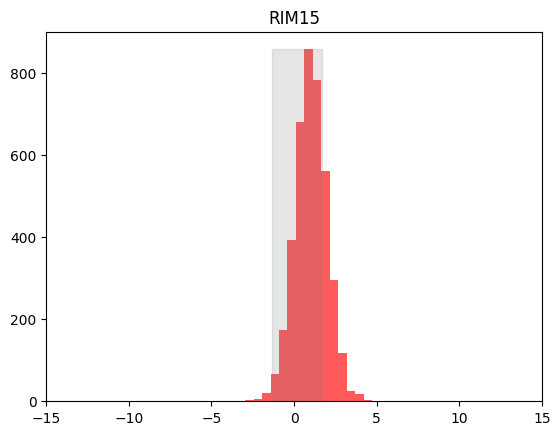

In [15]:
target = "KOG1"
int1 = {target: 0}
int2 = {target: -3.38}


sr_genes = ["RIM15"]

for i in range(len(sr_genes)):
    outcome = sr_genes[i]

    gt = model_data[(model_data["Protein"].isin([outcome])) & \
                        (model_data["Label"].isin(["CF"]))]
    if len(gt) > 0:
        logfc = gt["log2FC"].values
        se = gt["SE"].values
        df = gt["DF"].values
        h = se * scipy.stats.t.ppf((1 + .95) / 2., df)

        # if len(combo) > 1:
        # MScausality results
        lvm.intervention({list(int1.keys())[0]: (list(int1.values())[0] \
                                            - scale_metrics["mean"]) \
                                            / scale_metrics["std"]}, outcome)
        mscausality_int_low = lvm.intervention_samples
        lvm.intervention({list(int2.keys())[0]: (list(int2.values())[0] \
                                            - scale_metrics["mean"]) \
                                            / scale_metrics["std"]}, outcome)
        mscausality_int_high = lvm.intervention_samples

        mscausality_int_low = ((mscausality_int_low*scale_metrics["std"]) \
                    + scale_metrics["mean"])
        mscausality_int_high = ((mscausality_int_high*scale_metrics["std"]) \
                            + scale_metrics["mean"])
        mscausality_ate = mscausality_int_high.mean() - mscausality_int_low.mean()
        print(f"ATE: {mscausality_ate}")

        # frequentist_estimation = regression_with_interval(ml_data, target, 
        #                                                   outcome, [], -3.38)
        # eliator_ate = frequentist_estimation["mean"]
        # eliator_interval = frequentist_estimation["interval"]


        fig, ax = plt.subplots()

        height, bins, patches = ax.hist(
            mscausality_int_high - mscausality_int_low, 
            color="red", alpha=.65, bins=15)
        for  i in range(len(gt)):
            # ax.axvline(gt[i], color="black", linestyle="--", lw=2)
            # ax.hist(np.random.normal(logfc[i], se[i], 1000), color="grey", 
            #                          linestyle="--", lw=2, alpha=.5)
            ax.fill_betweenx([0, height.max()], 
                             logfc[i] - h[i], 
                             logfc[i] + h[i], color='grey', 
                             alpha=0.2)

        # ax.axvline(eliator_ate, color="black", linestyle="--", lw=2)
        
        # ax.errorbar(x=eliator_ate, y=height.max()/2, 
        #             xerr=(eliator_interval[1] - eliator_interval[0]) / 2, 
        #             capsize=10, elinewidth=3, capthick=3)
        
        ax.set_title(outcome)
        plt.xlim(-15,15)
        plt.show()
        # print(eliator_interval)

#### Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

tor_input = summarized_data[summarized_data["treatment_type"].isin(["control"])]
tor_input = tor_input.pivot_table(index="RUN", 
                              columns="name", 
                              values="LogIntensities", aggfunc='mean')

scaler = StandardScaler().fit(tor_input)
tor_input_scaled = pd.DataFrame(scaler.transform(tor_input),
                                columns=tor_input.columns)

imputer = KNNImputer(n_neighbors=10, keep_empty_features=True)
ml_data = pd.DataFrame(imputer.fit_transform(tor_input_scaled), 
                            columns=tor_input_scaled.columns)

In [29]:
# Compute correlations
target = "KOG1"
correlations = ml_data.corr()[target]

# Find top X columns (excluding the target column itself)
X = 50
top_columns = correlations.drop(target).abs().nlargest(X).index.tolist()

In [30]:
# Prep data
X = ml_data.loc[:, top_columns]
y = ml_data.loc[:, target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=1)

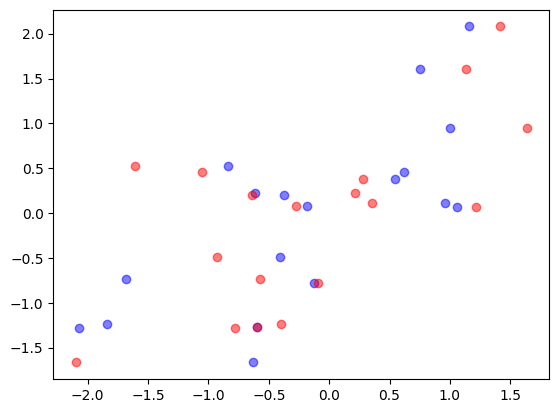

In [36]:
fig, ax = plt.subplots()
ax.scatter(X_train["DBP10"], y_train, color="blue", alpha=.5)
ax.scatter(X_train["SOL1"], y_train, color="red", alpha=.5)

In [32]:
lm = LinearRegression()
lm.fit(X_train, y_train)
lm.coef_
results = dict(
    zip(X.columns, lm.coef_)
    )
dict(sorted(results.items(), key=lambda item: item[1], reverse=True))

{'DBP10': 0.2383630029952282,
 'AGE2': 0.2189833092686131,
 'YCR034W': 0.19785842594479588,
 'CRP1': 0.1963290541546075,
 'SKP2': 0.19276971955202,
 'VTC5': 0.1913664410956532,
 'ECM30': 0.1498534535769859,
 'LST4': 0.14139692760014186,
 'ETT1': 0.13693502960610146,
 'GIS4': 0.13373900590239376,
 'OSH3': 0.1291206272526211,
 'RQC2': 0.11955073184483002,
 'YHR182W': 0.10806561866820578,
 'HSL1': 0.10354436917166968,
 'YFL042C': 0.09156134752725638,
 'LRE1': 0.0644084409612717,
 'SEC7': 0.05982164215170104,
 'TDA1': 0.05053860086560641,
 'BLM10': 0.04508145422955607,
 'TRM13': 0.02742540872454824,
 'PRK1': 0.0218189728794315,
 'MOB2': 0.014499793257147847,
 'CIC1': 0.012352581850410254,
 'AIM44': 0.007498037789314144,
 'HRK1': 0.00047340749329162994,
 'PUT3': -0.005938925911829616,
 'LAM4': -0.009936307468012703,
 'CRN1': -0.021382195353067186,
 'UBP9': -0.021976431508332357,
 'ZRG8': -0.022633333428659662,
 'RRP3': -0.026350683576655373,
 'SKG1': -0.027846063005295015,
 'ENP2': -0.03251

In [39]:
model_data[(model_data["Protein"].isin(['YCR034W', 'AGE2','BSP1', "DBP10", "KOG1"])) & \
                        (model_data["Label"].isin(["CF"]))]

,Protein,Label,log2FC,SE,Tvalue,DF,pvalue,adj.pvalue,issue,MissingPercentage,ImputationPercentage,treatment_id,treatment_type,phenotype_screened
20876,YCR034W,CF,1.575633,0.487435,3.232496,451.0,1.317105e-03,0.061704,NaN,0.616667,0.0,CF,drug,growth
23880,DBP10,CF,1.121229,0.909620,1.232634,385.0,2.184643e-01,0.974722,NaN,0.416667,0.0,CF,drug,growth
92281,KOG1,CF,-3.379449,0.640081,-5.279720,390.0,2.153697e-07,0.000039,NaN,0.500000,0.0,CF,drug,growth
94072,AGE2,CF,2.130442,0.695830,3.061727,321.0,2.386602e-03,0.095243,NaN,0.541667,0.0,CF,drug,growth
208338,BSP1,CF,0.665189,0.600421,1.107870,275.0,2.688862e-01,0.996803,NaN,0.666667,0.0,CF,drug,growth


#### Regression forest

In [ ]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

results = dict(
    zip(X.columns, 
        rf.feature_importances_)
        )

dict(sorted(results.items(), key=lambda item: item[1], reverse=True))

In [ ]:
model_data[(model_data["Protein"].isin(['YGR237C', 'TFC7','TRM13', "YHR182W"])) & \
                        (model_data["Label"].isin(["CF"]))]


#### XGBoost

In [ ]:
dtrain_reg = xgb.DMatrix(X_train, y_train)
params = {"objective": "reg:squarederror"}

n = 100
model = xgb.train(
   params=params,
   dtrain=dtrain_reg,
   num_boost_round=n,
)

xgb.plot_importance(model)

In [ ]:
model_data[(model_data["Protein"].isin(['TRM13', 'ISN1', 'CRP1'])) & \
                        (model_data["Label"].isin(["CF"]))]

## HOG network
### Define base graph

In [105]:
def mapk_network():

    graph = nx.DiGraph()

    # High osmolarity
    # graph.add_edge("SHO1", "STE11")
    # graph.add_edge("CLA4", "STE11")
    # graph.add_edge("STE11", "HOG1")
    graph.add_edge("SHO1", "HOG1")

    # graph.add_edge("SLN1", "SSK2")
    # graph.add_edge("SSK2", "HOG1")
    graph.add_edge("SLN1", "HOG1")

    # graph.add_edge("HOG1", "SMP1")
    # graph.add_edge("HOG1", "HOT1")
    # graph.add_edge("HOG1", "SKO1")
    # graph.add_edge("HOG1", "MSN2")
    # graph.add_edge("HOG1", "MSN4")

    # graph.add_edge("STE11", "KSS1")
    # graph.add_edge("KSS1", "DIG1")

    all_nodes = ["SSK2", "STE11", "HOG1", "PBS2", "SHO1", "SLN1", "SSK1", 
                 "STE20", "SMP1", "HOT1", "SKO1", "MSN2", "MSN4", "SSK22", 
                 "CLA4", "KSS1", "DIG1"]
    obs_nodes = ["SSK2", "STE11", "HOG1", "PBS2", "SHO1", "SLN1", "SSK1",
                  "STE20", "SMP1", "HOT1", "SKO1", "MSN2", "MSN4", "SSK22", 
                  "CLA4", "KSS1", "DIG1"]
        
    attrs = {node: (True if node not in obs_nodes and 
                    node != "\\n" else False) for node in all_nodes}
    
    nx.set_node_attributes(graph, attrs, name="hidden")
    # Use y0 to build ADMG
    y0_graph = NxMixedGraph()
    y0_graph = y0_graph.from_latent_variable_dag(graph, "hidden")

    return [graph, y0_graph]

nx_graph, y0_graph = mapk_network()

mapk_input = summarized_data[summarized_data["treatment_type"].isin(
    ["control"])]
mapk_input = mapk_input.pivot_table(index="RUN", 
                              columns="Gene", 
                              values="LogIntensities", aggfunc='mean')
mapk_input = mapk_input.loc[:,["SSK2", "STE11", "HOG1", "PBS2", "SHO1", "SLN1", "SSK1", "STE20", "SMP1", "HOT1", "SKO1", "MSN2", "MSN4", "SSK22", "CLA4", "KSS1", "DIG1"]]



In [106]:
# Basic Bayesian model
pyro.clear_param_store()
transformed_data = normalize(mapk_input, wide_format=True)
input_data = transformed_data["df"]
scale_metrics = transformed_data["adj_metrics"]
input_data.reset_index(drop=True, inplace=True)

# Full imp Bayesian model
lvm = LVM(backend="numpyro")
lvm.fit(input_data, y0_graph)

Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]





Running chain 0:   0%|          | 0/2000 [00:03<?, ?it/s]



Running chain 0:   5%|▌         | 100/2000 [00:03<00:02, 790.57it/s]


Running chain 0:  15%|█▌        | 300/2000 [00:03<00:01, 1302.71it/s]


Running chain 0:  25%|██▌       | 500/2000 [00:03<00:00, 1514.84it/s]

Running chain 0:  35%|███▌      | 700/2000 [00:03<00:00, 1586.54it/s]





Running chain 0:  60%|██████    | 1200/2000 [00:04<00:00, 1719.85it/s]


Running chain 0:  70%|███████   | 1400/2000 [00:04<00:00, 1636.58it/s]


Running chain 0:  80%|████████  | 1600/2000 [00:04<00:00, 1571.47it/s]


Running chain 2: 100%|██████████| 2000/2000 [00:04<00:00, 438.42it/s] 


Running chain 0: 100%|██████████| 2000/2000 [00:04<00:00, 428.97it/s] 


Running chain 3: 100%|██████████| 2000/2000 [00:04<00:00, 421.63it/s] 


In [107]:
sho1_movers = model_data[(model_data["pvalue"] < .3) & 
                         (model_data["Protein"] == "SHO1")]["Label"].unique()
sln1_movers = model_data[(model_data["pvalue"] < .3) & 
                         (model_data["Protein"] == "SLN1")]["Label"].unique()
potential_validators = np.intersect1d(sho1_movers, sln1_movers)

In [108]:
model_data[(model_data["Label"].isin(potential_validators)) & 
           (model_data["Protein"] == "SHO1")]

,Protein,Label,log2FC,SE,Tvalue,DF,pvalue,adj.pvalue,issue,MissingPercentage,ImputationPercentage,treatment_id,treatment_type,phenotype_screened
58431,SHO1,CG,-1.039985,0.402820,-2.581764,408.0,0.010178,0.193286,NaN,0.409091,0.0,CG,C/N source,transcription
58434,SHO1,CN,-1.551378,0.442251,-3.507915,408.0,0.000502,0.016310,NaN,0.416667,0.0,CN,C/N source,protein expression
58447,SHO1,DM,-0.754896,0.442251,-1.706942,408.0,0.088594,0.709408,NaN,0.545455,0.0,DM,control,control
58448,SHO1,DP,-0.832430,0.442251,-1.882259,408.0,0.060512,0.622131,NaN,0.439394,0.0,DP,growth,control
58460,SHO1,GL,-1.614553,0.442251,-3.650765,408.0,0.000295,0.012618,NaN,0.569444,0.0,GL,C/N source,growth (colony size)
58464,SHO1,HS42,-0.887756,0.374231,-2.372213,408.0,0.018145,0.222251,NaN,0.575758,0.0,HS42,heat,transcription
58468,SHO1,I3,-0.670391,0.442251,-1.515862,408.0,0.130329,0.622905,NaN,0.466667,0.0,I3,pH,cytosol acidification
58469,SHO1,I5,-0.980628,0.442251,-2.217358,408.0,0.027149,0.205423,NaN,0.469697,0.0,I5,pH,cytosol acidification
58470,SHO1,I7,-0.692128,0.402820,-1.718207,408.0,0.086518,0.227188,NaN,0.500000,0.0,I7,pH,cytosol acidification
58472,SHO1,KA,-0.608026,0.442251,-1.374845,408.0,0.169934,0.353781,NaN,0.402778,0.0,KA,C/N source,sporulation


In [109]:
model_data[(model_data["Label"].isin(potential_validators)) & 
           (model_data["Protein"] == "SLN1")]

,Protein,Label,log2FC,SE,Tvalue,DF,pvalue,adj.pvalue,issue,MissingPercentage,ImputationPercentage,treatment_id,treatment_type,phenotype_screened
98028,SLN1,CG,0.853208,0.690424,1.235774,408.0,0.217254,0.688770,NaN,0.575758,0.0,CG,C/N source,transcription
98031,SLN1,CN,0.956971,0.741635,1.290354,408.0,0.197659,0.705817,NaN,0.666667,0.0,CN,C/N source,protein expression
98044,SLN1,DM,0.975342,0.741635,1.315125,408.0,0.189207,0.791460,NaN,0.606061,0.0,DM,control,control
98045,SLN1,DP,1.160542,0.741635,1.564843,408.0,0.118395,0.706232,NaN,0.666667,0.0,DP,growth,control
98057,SLN1,GL,0.935292,0.741635,1.261122,408.0,0.207986,0.574864,NaN,0.638889,0.0,GL,C/N source,growth (colony size)
98061,SLN1,HS42,0.978012,0.741635,1.318724,408.0,0.188001,0.660799,NaN,0.696970,0.0,HS42,heat,transcription
98065,SLN1,I3,-1.292226,0.918350,-1.407116,408.0,0.160154,0.652326,NaN,0.700000,0.0,I3,pH,cytosol acidification
98066,SLN1,I5,-0.995856,0.918350,-1.084397,408.0,0.278829,0.570282,NaN,0.696970,0.0,I5,pH,cytosol acidification
98067,SLN1,I7,-1.941368,0.812420,-2.389611,408.0,0.017319,0.083468,NaN,0.703704,0.0,I7,pH,cytosol acidification
98069,SLN1,KA,-1.872178,0.812420,-2.304445,408.0,0.021699,0.110165,NaN,0.666667,0.0,KA,C/N source,sporulation


In [110]:
model_data[(model_data["Label"].isin(["HS42", "ZC", "RN"])) & 
           (model_data["Protein"] == "SHO1")]

,Protein,Label,log2FC,SE,Tvalue,DF,pvalue,adj.pvalue,issue,MissingPercentage,ImputationPercentage,treatment_id,treatment_type,phenotype_screened
58464,SHO1,HS42,-0.887756,0.374231,-2.372213,408.0,0.018145,0.222251,NaN,0.575758,0.0,HS42,heat,transcription
58495,SHO1,RN,-0.592383,0.442251,-1.339474,408.0,0.181162,0.706565,NaN,0.347222,0.0,RN,oxidizer,growth (pooled culture)
58511,SHO1,ZC,-0.600957,0.374231,-1.605845,408.0,0.109082,0.884157,NaN,0.444444,0.0,ZC,DNA,growth (pooled culture)


In [111]:
model_data[(model_data["Label"].isin(["HS42", "ZC", "RN"])) & 
           (model_data["Protein"] == "SLN1")]

,Protein,Label,log2FC,SE,Tvalue,DF,pvalue,adj.pvalue,issue,MissingPercentage,ImputationPercentage,treatment_id,treatment_type,phenotype_screened
98061,SLN1,HS42,0.978012,0.741635,1.318724,408.0,0.188001,0.660799,NaN,0.696970,0.0,HS42,heat,transcription
98092,SLN1,RN,1.707251,0.918350,1.859042,408.0,0.063741,0.644420,NaN,0.722222,0.0,RN,oxidizer,growth (pooled culture)
98109,SLN1,ZC,0.789858,0.741635,1.065023,408.0,0.287496,0.884157,NaN,0.638889,0.0,ZC,DNA,growth (pooled culture)


In [112]:
model_data[(model_data["Label"].isin(["HS42", "ZC", "RN"])) & 
           (model_data["Protein"] == "HOG1")]

,Protein,Label,log2FC,SE,Tvalue,DF,pvalue,adj.pvalue,issue,MissingPercentage,ImputationPercentage,treatment_id,treatment_type,phenotype_screened
128516,HOG1,HS42,1.416782,0.939390,1.508194,354.0,0.132397,0.578560,NaN,0.704545,0.0,HS42,heat,transcription
128546,HOG1,RN,1.515871,1.242696,1.219824,354.0,0.223344,0.718535,NaN,0.666667,0.0,RN,oxidizer,growth (pooled culture)
128563,HOG1,ZC,1.719698,1.101533,1.561187,354.0,0.119373,0.884157,NaN,0.708333,0.0,ZC,DNA,growth (pooled culture)


ATE: 1.1497268676757812


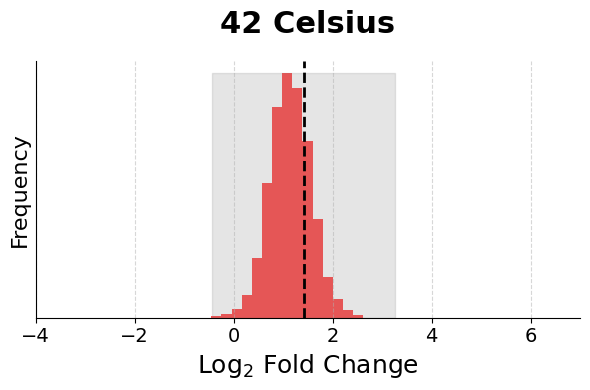

ATE: 1.1967811584472656


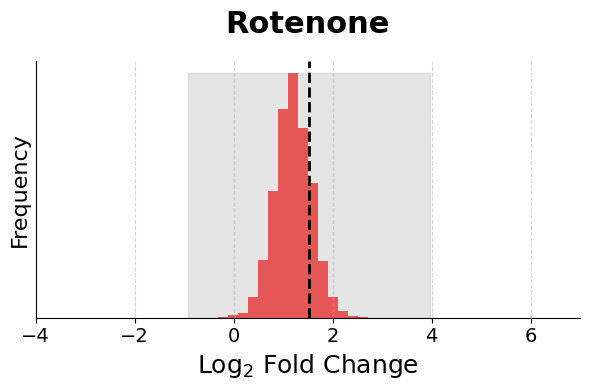

ATE: 0.8303794860839844


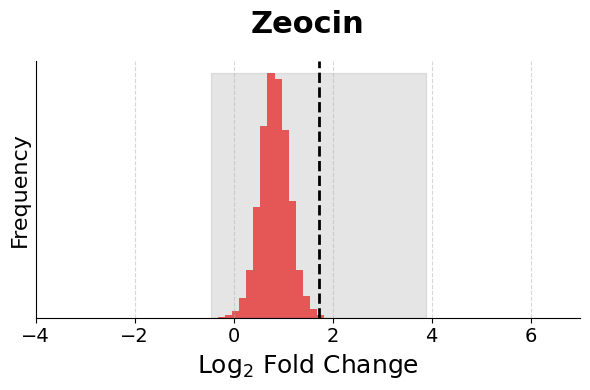

In [122]:
# target = "SLN1"
# int1 = {target: 0}
# int2 = {target: 1.278}
int1 = {"SHO1": 0, "SLN1": 0}
int2_dict = {"HS42" : {"SHO1": -.888, "SLN1": .978},
             "RN": {"SHO1": -.592, "SLN1": 1.707},
             "ZC": {"SHO1": -.601, "SLN1": .790}}
# int1 = {"SLN1": 0}
# int2_dict = {"HS42" : {"SLN1": .978},
#              "RN": {"SLN1": 1.707},
#              "ZC": {"SLN1": .790}}

labels = ["HS42", "RN", "ZC"]
label_title = {"HS42": "42 Celsius", 
               "RN": "Rotenone", 
               "ZC": "Zeocin"}
for i in range(len(labels)):
    outcome = "HOG1"

    gt = model_data[(model_data["Protein"].isin([outcome])) & \
                        (model_data["Label"].isin([labels[i]]))]
    if len(gt) > 0:
        logfc = gt["log2FC"].values
        se = gt["SE"].values
        df = gt["DF"].values
        h = se * scipy.stats.t.ppf((1 + .95) / 2., df)

        # if len(combo) > 1:
        # MScausality results
        int2 = int2_dict[labels[i]]
        if len(int1) > 0:
            lvm.intervention({list(int1.keys())[0]: (list(int1.values())[0] \
                                                - scale_metrics["mean"]) \
                                                / scale_metrics["std"],
                              list(int1.keys())[1]: (list(int1.values())[1] \
                                                - scale_metrics["mean"]) \
                                                / scale_metrics["std"]}, outcome)
            mscausality_int_low = lvm.intervention_samples
            
            lvm.intervention({list(int2.keys())[0]: (list(int2.values())[0] \
                                                - scale_metrics["mean"]) \
                                                / scale_metrics["std"],
                              list(int2.keys())[1]: (list(int2.values())[1] \
                                                - scale_metrics["mean"]) \
                                                / scale_metrics["std"]}, outcome)
            mscausality_int_high = lvm.intervention_samples        
        else:
            lvm.intervention({list(int1.keys())[0]: (list(int1.values())[0] \
                                                - scale_metrics["mean"]) \
                                                / scale_metrics["std"]}, outcome)
            mscausality_int_low = lvm.intervention_samples
            
            lvm.intervention({list(int2.keys())[0]: (list(int2.values())[0] \
                                                - scale_metrics["mean"]) \
                                                / scale_metrics["std"]}, outcome)
            mscausality_int_high = lvm.intervention_samples

        mscausality_int_low = ((mscausality_int_low*scale_metrics["std"]) \
                    + scale_metrics["mean"])
        mscausality_int_high = ((mscausality_int_high*scale_metrics["std"]) \
                            + scale_metrics["mean"])
        mscausality_ate = mscausality_int_high.mean() - mscausality_int_low.mean()
        print(f"ATE: {mscausality_ate}")

        # frequentist_estimation = regression_with_interval(ml_data, target, 
        #                                                   outcome, ["SSK2", "STE11", "SLN1"], 
        #                                                   list(int2.values())[0])

        # eliator_ate = frequentist_estimation["mean"]
        # eliator_interval = frequentist_estimation["interval"]


        fig, ax = plt.subplots(figsize=(6, 4))

        # # Plot histogram
        # msci_result = mscausality_int_high - mscausality_int_low
        # lower, upper = np.percentile(msci_result, [2.5, 97.5])
        # msci_result_abr = msci_result[(msci_result > lower) & (msci_result < upper)]
        # height, bins, patches = ax.hist(
        #     msci_result, 
        #     color="red", alpha=0.65, bins=10, label="Predicted log$_2$ FC"
        # )

        # # Add intervals with shading
        # ax.fill_betweenx(
        #     [0, height.max()], 
        #     logfc - h, 
        #     logfc + h, 
        #     color='grey', alpha=0.2, label="95% Confidence interval"
        # )
        # ax.axvline(logfc, color="black", linestyle="--", 
        #             lw=4, label="Observed log$_2$ FC")

        # # Customize plot
        # ax.set_title("HOG1 Pathway Model", fontsize=20, fontweight='bold')
        # ax.set_xlabel("Log$_2$ Fold Change", fontsize=18)
        # # ax.set_ylabel("Frequency", fontsize=14)
        # ax.set_xlim(-4, 7)
        # ax.tick_params(axis='both', which='major', labelsize=12)
        # ax.legend(fontsize=12, loc='upper left')

        # # Add grid for better readability
        # ax.grid(visible=True, linestyle='--', alpha=0.6)

        # # Display the plot
        # plt.tight_layout()
        # plt.show()
        # Plot histogram
        msci_result = mscausality_int_high - mscausality_int_low
        lower, upper = np.percentile(msci_result, [2.5, 97.5])
        msci_result_abr = msci_result[(msci_result > lower) & (msci_result < upper)]
        height, bins, patches = ax.hist(
            msci_result, 
            color="red", alpha=0.7, bins=15, label="Predicted log$_2$ FC"
        )

        # Add intervals with shading
        ax.fill_betweenx(
            [0, height.max()], 
            logfc - h, 
            logfc + h, 
            color='grey', alpha=0.2, label="95% Confidence Interval"
        )
        ax.axvline(logfc, color="black", linestyle="--", lw=2, label="Observed log$_2$ FC")

        # Customize plot
        ax.set_title(f"{label_title[labels[i]]}", fontsize=22, fontweight='bold', pad=20)
        ax.set_xlabel("Log$_2$ Fold Change", fontsize=18)
        ax.set_ylabel("Frequency", fontsize=16)
        ax.set_xlim(-4, 7)
        ax.tick_params(axis='both', which='major', labelsize=14)
        # ax.legend(fontsize=14, loc='upper left', frameon=False)
        # ax.legend(fontsize=14, loc='upper left', frameon=False, bbox_to_anchor=(1.05, 1))

        ax.set_yticks([])

        # Add grid for better readability
        ax.grid(visible=True, linestyle='--', alpha=0.5)

        # Enhance appearance
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        # Display the plot
        plt.tight_layout()
        plt.show()

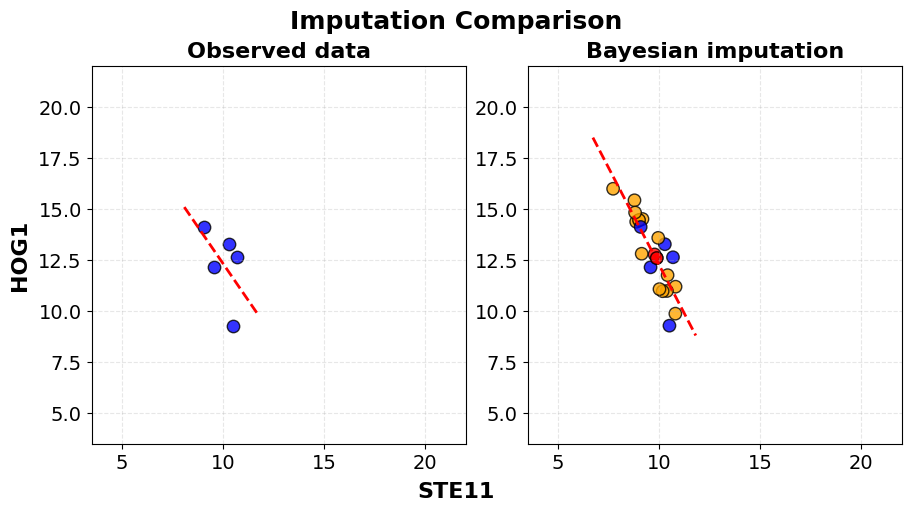

In [467]:
p1 = "STE11"
p2 = "HOG1"

model = lvm
imp_data = model.imputed_data
X_data = imp_data.loc[imp_data["protein"] == p1]
Z_data = imp_data.loc[imp_data["protein"] == p2]

X_backdoor_color = np.where(
    (X_data['imp_mean'].isna().values & Z_data['imp_mean'].isna().values), 
    "blue", 
    np.where((X_data['intensity'].isna().values \
              & Z_data['intensity'].isna().values), 
             "red", "orange"))

X_data = np.where(
    X_data['imp_mean'].isna(),
    X_data['intensity'], 
    X_data['imp_mean'])

Z_data = np.where(
    Z_data['imp_mean'].isna(),
    Z_data['intensity'], 
    Z_data['imp_mean'])


fig, ax = plt.subplots(1, 2, figsize=(9, 5), constrained_layout=True)

transformed_data = normalize(mapk_input, wide_format=True)
input_data = transformed_data["df"]

from scipy.stats import linregress

# Define a list of scatter plot configurations
temp = mapk_input.loc[:, [p1, p2]].dropna()
plots = [
    (temp.loc[:, p1], 
     temp.loc[:, p2], "blue",
     "Observed data", "Raf", "Erk"),
    (((X_data*transformed_data['adj_metrics']["std"]) \
     + transformed_data['adj_metrics']["mean"]), 
    ((Z_data*transformed_data['adj_metrics']["std"]) \
     + transformed_data['adj_metrics']["mean"]), 
     X_backdoor_color, "Bayesian imputation", "Raf", "Erk")
]

for i, (x, y, color, title, xlabel, ylabel) in enumerate(plots):

    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    line_x = np.linspace(x.min()-1, x.max()+1, 100)
    line_y = slope * line_x + intercept

    ax[i].scatter(x, y, color=color,
                  edgecolor='k', s=80, alpha=0.8)
    ax[i].plot(line_x, line_y, color='red', linestyle='--', 
               linewidth=2)
 
    ax[i].set_title(title, fontsize=16, fontweight='bold')
    # ax[i].set_xlabel(xlabel, fontsize=14)
    # ax[i].set_ylabel(ylabel, fontsize=14)
    ax[i].tick_params(axis='both', which='major', labelsize=14)
    ax[i].grid(True, linestyle='--', alpha=0.3)

    ax[i].set_xlim(3.5, 22)
    ax[i].set_ylim(3.5, 22)

fig.suptitle("Imputation Comparison", fontsize=18, fontweight='bold')
fig.supxlabel(p1, fontsize=16, fontweight='bold')
fig.supylabel(p2, fontsize=16, fontweight='bold')

plt.show()

In [462]:
from sklearn.linear_model import LinearRegression
temp = input_data.loc[:, ["SHO1", "HOG1"]].dropna()

lm  = LinearRegression()
lm.fit(temp[["SHO1"]], temp["HOG1"])

LinearRegression()

In [463]:
lm.coef_

array([-2.1687732])

### ML comparison

Prepare data

In [125]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error

control_input = summarized_data[summarized_data["treatment_type"].isin(["control"])]
control_input = control_input.pivot_table(index="RUN", columns="Gene", 
                                          values="LogIntensities", 
                                          aggfunc='mean')
control_input = control_input.loc[:, control_input.nunique(dropna=True) > 5]

drop = (-np.isnan(control_input.loc[:, "HOG1"])).values

# Prep data
X = control_input.loc[drop, [i for i in control_input.columns if i != "HOG1"]]
y = control_input.loc[drop, "HOG1"]

minmax_scaler = MinMaxScaler()
X_normalized = pd.DataFrame(
    minmax_scaler.fit_transform(X),
    columns = X.columns)

knn_imputer = KNNImputer(n_neighbors=20)
X_imputed = pd.DataFrame(
    knn_imputer.fit_transform(X_normalized),
    columns=X.columns)

scaler = StandardScaler()
X_standardized = pd.DataFrame(
    scaler.fit_transform(X_imputed),
    columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X_standardized, y, 
                                                    test_size=0.3, 
                                                    random_state=1)

#### Lasso


In [126]:
lm = Lasso(alpha=0.01, random_state=42)
lm.fit(X_train, y_train)

y_pred = lm.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")

lm.coef_
results = dict(
    zip(X.columns, lm.coef_)
    )
# dict(sorted(results.items(), key=lambda item: item[1], reverse=True))
lasso_top = dict(sorted(results.items(), 
                        key=lambda x: abs(x[1]), reverse=True)[:20])
lasso_top = pd.DataFrame({"Protein" : lasso_top.keys(),
                          "Coef": lasso_top.values()})
lasso_top

Mean Squared Error: 1.6638


,Protein,Coef
0,AIM24,0.345774
1,NGR1,0.280636
2,BRF1,-0.255607
3,CTK1,0.252360
4,MPC2,0.191440
5,FMP40,-0.185053
6,SGD1,-0.137389
7,IMP21,0.131129
8,CKB1,0.105620
9,DUR3,-0.076886


In [64]:
model_data[(model_data["Label"] == "RF") & 
           (model_data["Protein"].isin(["HOG1"]))]

,Protein,Label,log2FC,SE,Tvalue,DF,pvalue,adj.pvalue,issue,MissingPercentage,ImputationPercentage,treatment_id,treatment_type,phenotype_screened
128545,HOG1,RF,2.384942,1.007384,2.367462,354.0,0.018448,0.143216,NaN,0.6,0.0,RF,C/N source,transcription


In [105]:
pd.merge(model_data.loc[(model_data["Protein"].isin(lasso_top["Protein"])) & 
           (model_data["Label"] == "RF"), 
           ["Protein", "log2FC", "SE", "pvalue"]], lasso_top, how="left",
            left_on="Protein", right_on="Protein").sort_values("Coef", ascending=False)

,Protein,log2FC,SE,pvalue,Coef
11,HCA4,0.264464,0.830277,7.503089e-01,0.328388
15,LIP1,0.459064,0.772079,5.524776e-01,0.211049
14,MYO5,1.388165,1.322233,2.943959e-01,0.137043
16,NPR1,-0.562420,0.752378,4.552884e-01,0.135288
1,LDB16,1.204846,0.866712,1.653261e-01,0.130885
0,GRS1,1.647287,0.929354,7.720569e-02,0.092518
9,TNA1,-0.017413,0.795659,9.825645e-01,0.057860
4,IPT1,0.492936,0.886933,5.793198e-01,0.046113
7,GTA1,0.421790,0.673394,5.314861e-01,0.025547
10,RSC30,0.182105,1.089303,8.673552e-01,0.022999


In [106]:
results["SHO1"]

-0.0

#### Regression Forest

In [80]:
from sklearn.feature_selection import SelectKBest, f_regression

k = 50  # Number of features to select
selector = SelectKBest(score_func=f_regression, k=k)
X_selected = selector.fit_transform(X_standardized, y)
X_selected = pd.DataFrame(X_selected, columns=X.columns[selector.get_support()])

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, 
                                                    test_size=0.3, 
                                                    random_state=1)

rf = RandomForestRegressor()
rf.fit(X_train, y_train)


y_pred = rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")

results = dict(
    zip(X_selected.columns, 
        rf.feature_importances_)
        )

rf_top = dict(sorted(results.items(), 
                        key=lambda x: abs(x[1]), reverse=True)[:20])
rf_top = pd.DataFrame({"Protein" : rf_top.keys(),
                          "Coef": rf_top.values()})
rf_top

Mean Squared Error: 0.8368


,Protein,Coef
0,CSR2,0.128118
1,SHS1,0.080082
2,SPA2,0.071704
3,DIP5,0.067790
4,ALE1,0.058194
5,NCE102,0.053614
6,PIK1,0.031062
7,SUR7,0.029256
8,SUM1,0.028747
9,SFB2,0.028129


In [81]:
model_data[(model_data["Label"] == "RF") & 
           (model_data["Protein"].isin(["HOG1"]))]

,Protein,Label,log2FC,SE,Tvalue,DF,pvalue,adj.pvalue,issue,MissingPercentage,ImputationPercentage,treatment_id,treatment_type,phenotype_screened
128545,HOG1,RF,2.384942,1.007384,2.367462,354.0,0.018448,0.143216,NaN,0.6,0.0,RF,C/N source,transcription


In [86]:
pd.merge(model_data.loc[(model_data["Protein"].isin(rf_top["Protein"])) & 
           (model_data["Label"] == "RF"), 
           ["Protein", "log2FC", "SE", "pvalue"]], rf_top, how="left",
            left_on="Protein", right_on="Protein"
            ).sort_values("Coef", ascending=False)

,Protein,log2FC,SE,pvalue,Coef
18,CSR2,2.491516,0.876744,0.004701,0.128118
0,SHS1,-1.770559,0.522553,0.000770,0.080082
8,SPA2,-0.004050,0.611385,0.994718,0.071704
17,DIP5,0.670377,0.932822,0.472781,0.067790
16,ALE1,-0.481011,0.896682,0.592048,0.058194
19,NCE102,0.354853,0.533047,0.505980,0.053614
14,PIK1,1.252884,0.794321,0.115443,0.031062
10,SUR7,0.659067,0.933018,0.480316,0.029256
2,SUM1,1.231659,0.829348,0.138254,0.028747
12,SFB2,2.014723,0.706095,0.004566,0.028129


#### XGBoost

In [88]:
dtrain_reg = xgb.DMatrix(X_train, label=y_train, 
                         feature_names=list(X_selected.columns))
params = {"objective": "reg:squarederror"}

n = 100
model = xgb.train(
   params=params,
   dtrain=dtrain_reg,
   num_boost_round=n,
)

y_pred = model.predict(xgb.DMatrix(X_test))
mse = mean_squared_error(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
results = model.get_score(importance_type='gain')

# results = dict(
#     zip(X.columns, 
#         rf.feature_importances_)
#         )

xg_top = dict(sorted(results.items(), 
                        key=lambda x: abs(x[1]), reverse=True)[:20])
xg_top = pd.DataFrame({"Protein" : xg_top.keys(),
                          "Coef": xg_top.values()})
xg_top

Mean Squared Error: 0.5128


,Protein,Coef
0,CSR2,0.588669
1,ALE1,0.161328
2,CKI1,0.090667
3,ABF1,0.086000
4,NCE102,0.000406
5,HNM1,0.000364


In [89]:
pd.merge(model_data.loc[(model_data["Protein"].isin(xg_top["Protein"])) & 
           (model_data["Label"] == "RF"), 
           ["Protein", "log2FC", "SE", "pvalue"]], xg_top, how="left",
            left_on="Protein", right_on="Protein"
            ).sort_values("Coef", ascending=False)

,Protein,log2FC,SE,pvalue,Coef
4,CSR2,2.491516,0.876744,0.004701,0.588669
3,ALE1,-0.481011,0.896682,0.592048,0.161328
2,CKI1,-0.174933,0.986244,0.859299,0.090667
1,ABF1,1.341047,0.594843,0.024389,0.086000
5,NCE102,0.354853,0.533047,0.505980,0.000406
0,HNM1,0.389078,1.010720,0.700472,0.000364


## MAPK network

In [88]:
input["MKK1"]

RUN
178    12.792152
179          NaN
180          NaN
181    12.109570
182    13.451406
493          NaN
494    12.958358
495    11.335953
496          NaN
497          NaN
498          NaN
499          NaN
500    13.416280
501    12.027167
502          NaN
503    12.943346
504          NaN
505    11.712624
506    12.014099
507    12.000938
508    12.535540
509    12.771810
510          NaN
511          NaN
512    12.949107
513    11.117579
514          NaN
515          NaN
516    12.920819
517    10.134009
518    16.004279
519    12.983881
520          NaN
521    13.397981
Name: MKK1, dtype: float64

<Axes: xlabel='STE11', ylabel='DIG1'>

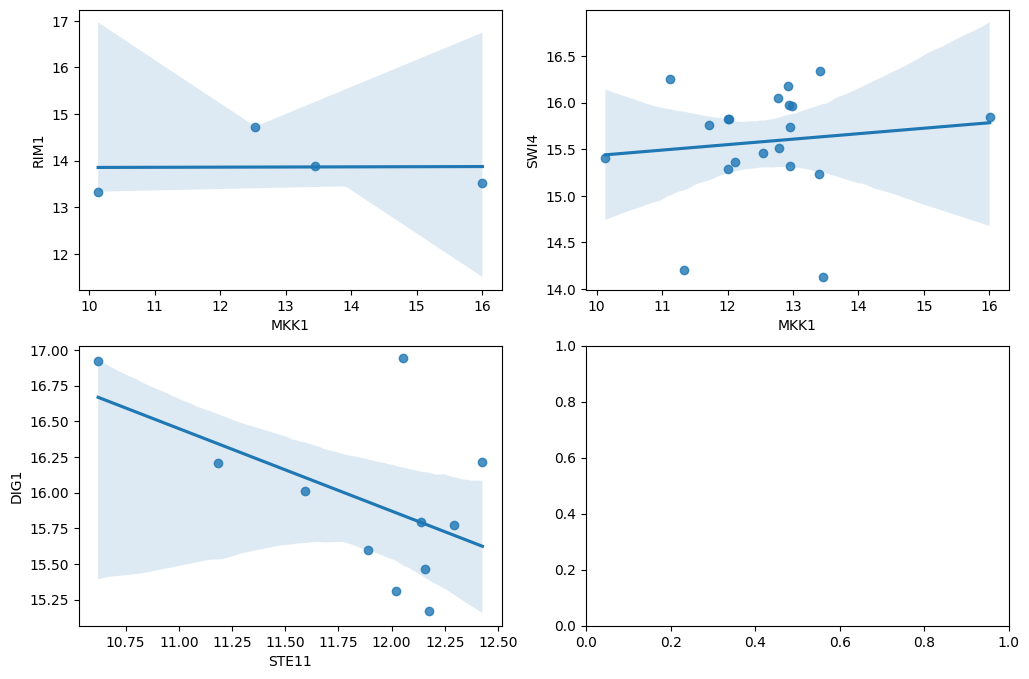

In [91]:
fig, ax = plt.subplots(2,2, figsize=(12,8))
sns.regplot(x=input["MKK1"], y=input["RIM1"], ax=ax[0,0])
sns.regplot(x=input["MKK1"], y=input["SWI4"], ax=ax[0,1])
sns.regplot(x=input["STE11"], y=input["DIG1"], ax=ax[1,0])
# sns.regplot(x=input["STE20"], y=input["DIG2"], ax=ax[1,1])

In [98]:
def pheromone_network():

    graph = nx.DiGraph()

    graph.add_edge("STE11", "KSS1")
    # graph.add_edge("STE11", "DIG1")
    # graph.add_edge("STE11", "DIG2")
    # graph.add_edge("STE11", "FAR1")
    # graph.add_edge("DIG1", "STE12")
    # graph.add_edge("DIG2", "STE12")


    all_nodes = ["STE11", "KSS1"]
    obs_nodes = ["STE11", "KSS1"]
        
    attrs = {node: (True if node not in obs_nodes and 
                    node != "\\n" else False) for node in all_nodes}
    
    nx.set_node_attributes(graph, attrs, name="hidden")
    # Use y0 to build ADMG
    y0_graph = NxMixedGraph()
    y0_graph = y0_graph.from_latent_variable_dag(graph, "hidden")

    return [graph, y0_graph]

def starvation_network():

    graph = nx.DiGraph()

    graph.add_edge("SHO1", "STE20")
    graph.add_edge("STE20", "STE11")
    graph.add_edge("STE11", "KSS1")
    graph.add_edge("KSS1", "DIG1")


    all_nodes = ["SHO1", "STE20", "STE11", "KSS1", "DIG1"]
    obs_nodes = ["SHO1", "STE20", "STE11", "KSS1", "DIG1"]
        
    attrs = {node: (True if node not in obs_nodes and 
                    node != "\\n" else False) for node in all_nodes}
    
    nx.set_node_attributes(graph, attrs, name="hidden")
    # Use y0 to build ADMG
    y0_graph = NxMixedGraph()
    y0_graph = y0_graph.from_latent_variable_dag(graph, "hidden")

    return [graph, y0_graph]

In [99]:
nx_graph, y0_graph = pheromone_network()

In [102]:
pher_input = input.loc[:,["STE11", "KSS1"]
        ]


In [103]:
# Basic Bayesian model
pyro.clear_param_store()
transformed_data = normalize(pher_input, wide_format=True)
input_data = transformed_data["df"]
scale_metrics = transformed_data["adj_metrics"]
input_data.reset_index(drop=True, inplace=True)

# Full imp Bayesian model
lvm = LVM(backend="numpyro")
lvm.fit(input_data, y0_graph)

Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]





Running chain 0:   0%|          | 0/2000 [00:03<?, ?it/s]












Running chain 0:   5%|▌         | 100/2000 [00:04<00:11, 169.68it/s]




Running chain 0:  10%|█         | 200/2000 [00:04<00:06, 279.39it/s]


Running chain 0:  15%|█▌        | 300/2000 [00:04<00:04, 372.76it/s]


Running chain 2: 100%|██████████| 2000/2000 [00:05<00:00, 399.09it/s] 


Running chain 0: 100%|██████████| 2000/2000 [00:07<00:00, 276.73it/s]


In [75]:
model_data[(model_data["Label"] == "AF") & (model_data["adj.pvalue"] < .5)]

,Protein,Label,log2FC,SE,Tvalue,DF,pvalue,adj.pvalue,issue,MissingPercentage,ImputationPercentage,treatment_id,treatment_type,phenotype_screened
20495,RIM1,AF,-1.958411,0.544587,-3.596140,80.0,5.572101e-04,1.759192e-01,NaN,0.800000,0.0,AF,drug,transcription
43574,SVF1,AF,-5.757533,1.660601,-3.467138,66.0,9.303971e-04,2.284642e-01,NaN,0.800000,0.0,AF,drug,transcription
67900,HSF1,AF,-1.567417,0.346820,-4.519396,344.0,8.540515e-06,9.437269e-03,NaN,0.500000,0.0,AF,drug,transcription
75557,KSS1,AF,2.183966,0.725432,3.010574,80.0,3.487889e-03,4.817647e-01,NaN,0.650000,0.0,AF,drug,transcription
92073,ROF1,AF,-1.363335,0.314446,-4.335672,7.0,3.414085e-03,4.817647e-01,NaN,1.000000,0.0,AF,drug,transcription
104628,FAR1,AF,1.394048,0.335027,4.161006,231.0,4.471558e-05,3.294048e-02,NaN,0.433333,0.0,AF,drug,transcription
105651,PHO90,AF,1.042530,0.334497,3.116709,271.0,2.025491e-03,3.730280e-01,NaN,0.600000,0.0,AF,drug,transcription
107498,SSC1,AF,-3.174860,0.950036,-3.341832,85.0,1.238630e-03,2.737373e-01,NaN,0.950000,0.0,AF,drug,transcription
136681,STE11,AF,2.277811,0.544967,4.179721,64.0,9.032934e-05,4.990696e-02,NaN,0.600000,0.0,AF,drug,transcription
147660,AVO2,AF,1.982509,0.572178,3.464847,192.0,6.543414e-04,1.807618e-01,NaN,0.300000,0.0,AF,drug,transcription


In [97]:
model_data[(model_data["Label"].isin(["AF", "AF2"])) & 
           (model_data["Protein"] == "KSS1")]# & (model_data["pvalue"] < .05)]

,Protein,Label,log2FC,SE,Tvalue,DF,pvalue,adj.pvalue,issue,MissingPercentage,ImputationPercentage,treatment_id,treatment_type,phenotype_screened
75557,KSS1,AF,2.183966,0.725432,3.010574,80.0,0.003488,0.481765,NaN,0.650000,0.0,AF,drug,transcription
75558,KSS1,AF2,0.423481,0.949813,0.445857,80.0,0.656905,0.941806,NaN,0.636364,0.0,AF2,cell cylce,transcription


In [94]:
model_data[#(model_data["Label"].isin(["NG", "NN", "NA", "LG", "LP", "SP"])) & 
           (model_data["Protein"] == "STE11") & (model_data["pvalue"] < .05)]

,Protein,Label,log2FC,SE,Tvalue,DF,pvalue,adj.pvalue,issue,MissingPercentage,ImputationPercentage,treatment_id,treatment_type,phenotype_screened
136681,STE11,AF,2.277811,0.544967,4.179721,64.0,0.000090,0.049907,NaN,0.600000,0.0,AF,drug,transcription
136682,STE11,AF2,2.311580,0.544967,4.241686,64.0,0.000073,0.003834,NaN,0.863636,0.0,AF2,cell cylce,transcription
136694,STE11,CA,1.879806,0.929499,2.022386,64.0,0.047320,0.318133,NaN,0.833333,0.0,CA,osmostressor,growth (colony size)
136733,STE11,MN,-1.697539,0.697124,-2.435058,64.0,0.017687,0.974426,NaN,0.875000,0.0,MN,metal,"toxicity, half maximal Effective Concentration,"


ATE: 0.5628070831298828


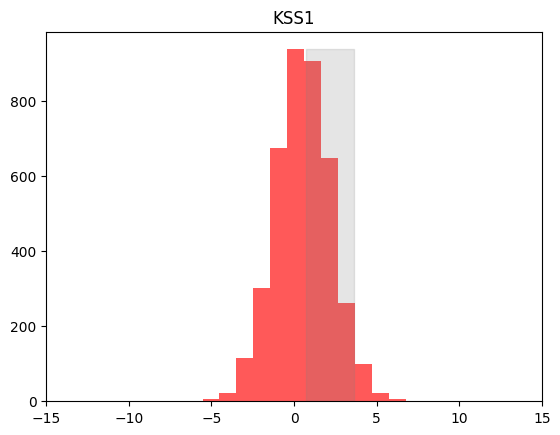

In [104]:
target = "STE11"
int1 = {target: 0}
int2 = {target: 2.28}

sr_genes=["KSS1"]
for i in range(len(sr_genes)):
    outcome = sr_genes[i]

    gt = model_data[(model_data["Protein"].isin([outcome])) & \
                        (model_data["Label"].isin(["AF"]))]
    if len(gt) > 0:
        logfc = gt["log2FC"].values
        se = gt["SE"].values
        df = gt["DF"].values
        h = se * scipy.stats.t.ppf((1 + .95) / 2., df)

        # if len(combo) > 1:
        # MScausality results
        lvm.intervention({list(int1.keys())[0]: (list(int1.values())[0] \
                                            - scale_metrics["mean"]) \
                                            / scale_metrics["std"]}, outcome)
        mscausality_int_low = lvm.intervention_samples
        lvm.intervention({list(int2.keys())[0]: (list(int2.values())[0] \
                                            - scale_metrics["mean"]) \
                                            / scale_metrics["std"]}, outcome)
        mscausality_int_high = lvm.intervention_samples

        mscausality_int_low = ((mscausality_int_low*scale_metrics["std"]) \
                    + scale_metrics["mean"])
        mscausality_int_high = ((mscausality_int_high*scale_metrics["std"]) \
                            + scale_metrics["mean"])
        mscausality_ate = mscausality_int_high.mean() - mscausality_int_low.mean()
        print(f"ATE: {mscausality_ate}")


        fig, ax = plt.subplots()

        height, bins, patches = ax.hist(
            mscausality_int_high - mscausality_int_low, 
            color="red", alpha=.65, bins=12)
        for  i in range(len(gt)):
            # ax.axvline(gt[i], color="black", linestyle="--", lw=2)
            # ax.hist(np.random.normal(logfc[i], se[i], 1000), color="grey", 
            #                          linestyle="--", lw=2, alpha=.5)
            ax.fill_betweenx([0, height.max()], 
                             logfc[i] - h[i], 
                             logfc[i] + h[i], color='grey', 
                             alpha=0.2)

        
        ax.set_title(outcome)
        plt.xlim(-15,15)
        plt.show()


In [ ]:
p1 = "STE11"
p2 = "KSS1"

model = lvm
imp_data = model.imputed_data
X_data = imp_data.loc[imp_data["protein"] == p1]
Z_data = imp_data.loc[imp_data["protein"] == p2]

X_backdoor_color = np.where(
    (X_data['imp_mean'].isna().values & Z_data['imp_mean'].isna().values), 
    "blue", 
    np.where((X_data['intensity'].isna().values \
              & Z_data['intensity'].isna().values), 
             "red", "orange"))

X_data = np.where(
    X_data['imp_mean'].isna(),
    X_data['intensity'], 
    X_data['imp_mean'])

Z_data = np.where(
    Z_data['imp_mean'].isna(),
    Z_data['intensity'], 
    Z_data['imp_mean'])


fig, ax = plt.subplots(1, 2, figsize=(9, 5), constrained_layout=True)

transformed_data = normalize(mapk_input, wide_format=True)
input_data = transformed_data["df"]

from scipy.stats import linregress

# Define a list of scatter plot configurations
temp = input.loc[:, [p1, p2]].dropna()
plots = [
    (temp.loc[:, p1], 
     temp.loc[:, p2], "blue",
     "Observed data", "Raf", "Erk"),
    (((X_data*transformed_data['adj_metrics']["std"]) \
     + transformed_data['adj_metrics']["mean"]), 
    ((Z_data*transformed_data['adj_metrics']["std"]) \
     + transformed_data['adj_metrics']["mean"]), 
     X_backdoor_color, "Bayesian imputation", "Raf", "Erk")
]

for i, (x, y, color, title, xlabel, ylabel) in enumerate(plots):

    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    line_x = np.linspace(x.min()-1, x.max()+1, 100)
    line_y = slope * line_x + intercept

    ax[i].scatter(x, y, color=color,
                  edgecolor='k', s=80, alpha=0.8)
    ax[i].plot(line_x, line_y, color='red', linestyle='--', 
               linewidth=2)
 
    ax[i].set_title(title, fontsize=16, fontweight='bold')
    # ax[i].set_xlabel(xlabel, fontsize=14)
    # ax[i].set_ylabel(ylabel, fontsize=14)
    ax[i].tick_params(axis='both', which='major', labelsize=14)
    ax[i].grid(True, linestyle='--', alpha=0.3)

    ax[i].set_xlim(3.5, 22)
    ax[i].set_ylim(3.5, 22)

fig.suptitle("Imputation Comparison", fontsize=18, fontweight='bold')
fig.supxlabel(p1, fontsize=16, fontweight='bold')
fig.supylabel(p2, fontsize=16, fontweight='bold')

plt.show()